# A Simulation Study for Time-varying coefficients

In [76]:
import math
from math import pi
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import cdist

from orbit.estimators.pyro_estimator import PyroEstimatorVI
from orbit.estimators.stan_estimator import StanEstimatorMAP
from orbit.diagnostics.metrics import smape
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data

from orbit.utils.plot import get_orbit_style
orbit_style = get_orbit_style()
plt.style.use(orbit_style)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Simulation Modules

In [2]:
def sim_data_seasonal(n, RS):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)
    # make the time varing coefs  
    tau = np.arange(1, n+1)/n
    data = pd.DataFrame({
        'tau': tau,
        'date': pd.date_range(start='1/1/2018', periods=n),
        'beta1': 2 * tau,
        'beta2': 1.01 + np.sin(2*pi*tau),
        'beta3': 1.01 + np.sin(4*pi*(tau-1/8)),
#         'x1': stats.chi2.rvs(4, size=n),
#         'x2': stats.t.rvs(2, size=n),
#         'x3': stats.t.rvs(2, size=n),
        'x1': np.random.normal(0, 10, size=n),
        'x2': np.random.normal(0, 10, size=n),
        'x3': np.random.normal(0, 10, size=n),
        'trend': np.cumsum(np.concatenate((np.array([1]), np.random.normal(0, 0.1, n-1)))),
        'error': np.random.normal(0, 1, size=n) #stats.t.rvs(30, size=n),#
    })
    
    # add error to the data 
    #err_cov = np.exp(-cdist(data.tau.values.reshape(n, -1), data.tau.values.reshape(n, -1), 'euclid')/10)
    #L = np.linalg.cholesky(err_cov).T
    #data['error2'] = L.dot(stats.chi2.rvs(100, size=n))
    
    data['y'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    #data['y2'] = data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error2
    #data['y3'] = data.trend + data.x1 * data.beta1 + data.x2 * data.beta2 + data.x3 * data.beta3 + data.error
    return data

def sim_data_rw(n, RS, p=3):
    """ coefficients curve are sine-cosine like
    """
    np.random.seed(RS)

    # initializing coefficients at zeros, simulate all coefficient values
    lev = np.cumsum(np.concatenate((np.array([5.0]), np.random.normal(0, 0.01, n-1))))
    beta = np.concatenate(
        [np.random.uniform(0.05, 0.12, size=(1,p)),
         np.random.normal(0.0, 0.01, size=(n-1,p))], 
            axis=0)
    beta = np.cumsum(beta, 0)

    # simulate regressors
    covariates = np.random.normal(0, 10, (n, p))

    # observation with noise
    y = lev + (covariates * beta).sum(-1) + 0.3 * np.random.normal(0, 1, n)

    regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
    data = pd.DataFrame(covariates, columns=regressor_col)
    beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
    beta_data = pd.DataFrame(beta, columns=beta_col)
    data = pd.concat([data, beta_data], axis=1)
        
    data['y'] = y
    data['date'] = pd.date_range(start='1/1/2018', periods=len(y))

    return data

In [3]:
seas_data = sim_data_seasonal(n=1000, RS=8888)
seas_data.head(10)

,tau,date,beta1,beta2,beta3,x1,x2,x3,trend,error,y
0,0.001,2018-01-01,0.002,1.016283,0.010079,-4.112205,6.235252,8.318071,1.000000,-0.772024,5.640371
1,0.002,2018-01-02,0.004,1.022566,0.010316,-0.499279,-14.816010,3.641032,1.075149,1.243571,-13.871215
2,0.003,2018-01-03,0.006,1.028848,0.010711,1.826034,-2.897783,-17.144133,1.278494,-0.352154,-3.506200
3,0.004,2018-01-04,0.008,1.035130,0.011263,24.874740,5.439502,6.055187,1.104741,-0.571943,5.325848
4,0.005,2018-01-05,0.010,1.041411,0.011973,1.734577,-16.383980,9.075009,1.059079,-0.218024,-17.154473
5,0.006,2018-01-06,0.012,1.047690,0.012841,-11.059695,12.494699,2.577940,1.088198,0.541397,13.532358
6,0.007,2018-01-07,0.014,1.053968,0.013866,-6.065916,4.606459,-9.182241,1.153368,0.474600,5.117413
7,0.008,2018-01-08,0.016,1.060244,0.015049,0.945238,3.450288,13.376691,1.244678,2.122431,5.997009
8,0.009,2018-01-09,0.018,1.066519,0.016389,11.628231,11.262647,16.722551,1.167512,0.439053,12.934243
9,0.010,2018-01-10,0.020,1.072791,0.017885,2.740874,2.271040,-17.405263,1.352738,0.496264,2.676133


In [4]:
rw_data = sim_data_rw(n=300, RS=8888, p=3)
rw_data.head(10)

,x1,x2,x3,beta1,beta2,beta3,y,date
0,1.118687,12.579436,-18.705481,0.083833,0.118039,0.106882,4.238243,2018-01-01
1,0.251493,5.300673,8.974563,0.081579,0.116649,0.116075,6.762299,2018-01-02
2,-12.535904,2.134341,4.224095,0.083838,0.112736,0.121694,4.576347,2018-01-03
3,-6.830381,3.094571,-1.926185,0.067788,0.111347,0.126284,4.497561,2018-01-04
4,-3.370150,3.899625,-3.083105,0.086333,0.099882,0.138985,5.230371,2018-01-05
5,-3.364463,-4.186151,13.149254,0.076195,0.108590,0.142555,6.102766,2018-01-06
6,-3.663559,-14.795409,-1.731279,0.091534,0.099006,0.156208,3.284992,2018-01-07
7,7.205991,-5.623366,-11.806551,0.100954,0.099507,0.160083,2.529016,2018-01-08
8,-3.643661,3.799626,-1.398166,0.100640,0.087954,0.163894,4.908982,2018-01-09
9,9.222329,1.695171,-0.896493,0.098496,0.085971,0.172410,5.529784,2018-01-10


## Test on how knots and segements interact

In [5]:
from orbit.utils.knots import get_knot_idx_by_dist, get_knot_idx, get_knot_dates

In [6]:
knot_idx = get_knot_idx(num_of_obs=400, num_of_segments=10)
knot_idx

array([  0,  39,  79, 119, 159, 199, 239, 279, 319, 359, 399])

In [7]:
knot_idx = get_knot_idx(num_of_obs=250, knot_distance=10)
knot_idx

array([  0,   9,  19,  29,  39,  49,  59,  69,  79,  89,  99, 109, 119,
       129, 139, 149, 159, 169, 179, 189, 199, 209, 219, 229, 239, 249])

In [8]:
date_array = rw_data['date'].values
date_array.dtype

dtype('<M8[ns]')

In [9]:
date_array[:5]

array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', '2018-01-04T00:00:00.000000000',
       '2018-01-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [10]:
knot_dates=['2018-01-01','2018-07-01','2018-09-09']
knot_dates = np.array(knot_dates, dtype='datetime64')
knot_dates[:5]

array(['2018-01-01', '2018-07-01', '2018-09-09'], dtype='datetime64[D]')

In [16]:
knot_idx = get_knot_idx(date_array=date_array, knot_dates=knot_dates)
knot_idx

In [12]:
infer_freq = pd.infer_freq(date_array)

In [13]:
knot_idx * np.timedelta64(1, infer_freq)  + date_array[0]

array(['2018-01-01T00:00:00.000000000', '2018-01-10T00:00:00.000000000',
       '2018-01-20T00:00:00.000000000', '2018-01-30T00:00:00.000000000',
       '2018-02-09T00:00:00.000000000', '2018-02-19T00:00:00.000000000',
       '2018-03-01T00:00:00.000000000', '2018-03-11T00:00:00.000000000',
       '2018-03-21T00:00:00.000000000', '2018-03-31T00:00:00.000000000',
       '2018-04-10T00:00:00.000000000', '2018-04-20T00:00:00.000000000',
       '2018-04-30T00:00:00.000000000', '2018-05-10T00:00:00.000000000',
       '2018-05-20T00:00:00.000000000', '2018-05-30T00:00:00.000000000',
       '2018-06-09T00:00:00.000000000', '2018-06-19T00:00:00.000000000',
       '2018-06-29T00:00:00.000000000', '2018-07-09T00:00:00.000000000',
       '2018-07-19T00:00:00.000000000', '2018-07-29T00:00:00.000000000',
       '2018-08-08T00:00:00.000000000', '2018-08-18T00:00:00.000000000',
       '2018-08-28T00:00:00.000000000', '2018-09-07T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [15]:
get_knot_dates(date_array[0], knot_idx, infer_freq)

# Random Walk Coefficients Simulation Study

## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [17]:
from orbit.models import KTR

In [18]:
p = 3
regressor_col = ['x{}'.format(pp) for pp in range(1, p + 1)]

In [19]:
ktrx_neutral = KTR(
    response_col='y',
    date_col='date',
    level_knot_scale=0.1,
    
    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[1.0] * len(regressor_col),
    regressor_knot_scale=[0.5] * len(regressor_col),

    level_segments=10,
    regression_segments=10,
    
    regression_rho=0.05,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,

    flat_multiplier=True,
)

INFO:root:Using 501 steps, 1000 samples, 0.2 learning rate and 100 particles for SVI.


In [20]:
ktrx_neutral.fit(df=rw_data)  

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5f019f85b312f9bb6f21f9ec9a33c1c4 NOW.
In file included from /var/folders/ln/k7ffpq9d62z_r4bhk5vyj6z40000gn/T/pystan_75g95vtl/stanfit4anon_model_5f019f85b312f9bb6f21f9ec9a33c1c4_5767594763401460140.cpp:701:
In file included from /Users/ariel.jiang/Documents/python_virtual_envs/orbit/env_orbit/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:4:
In file included from /Users/ariel.jiang/Documents/python_virtual_envs/orbit/env_orbit/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/ariel.jiang/Documents/python_virtual_envs/orbit/env_orbit/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1944:
/Users/ariel.jiang/Documents/python_virtual_envs/orbit/env_orbit/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VER

Initial log joint probability = -1746.54
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -510.885     0.0488094       32.4314      0.2891      0.2891       23   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -508.614   0.000254171       33.3664      0.2697      0.8316       50   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -508.605   5.50184e-07       32.6815      0.3379           1       78   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70      -508.605   3.22758e-08       33.2243      0.1599      0.1599       94   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
step    0 loss = 1530.3, scale = 0.10223
step   50 loss = 353.14, scale = 0.053381
step  100 loss = 341.11, scale = 0.054994
step  150 lo

In [21]:
idx = 3

In [43]:
from orbit.constants.palette import PredictionPaletteClassic as PredPal

In [52]:
PredPal.PREDICTION_LINE.value

'#276EF1'

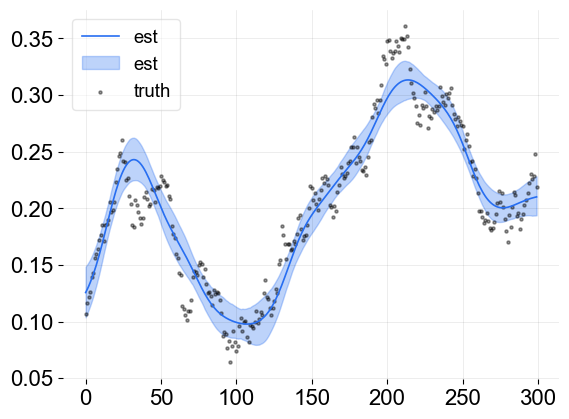

In [63]:
coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True)
x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', color=PredPal.PREDICTION_LINE.value)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', alpha=0.3, color=PredPal.PREDICTION_LINE.value)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=5, alpha=0.4, color=PredPal.ACTUAL_OBS.value)
plt.legend();

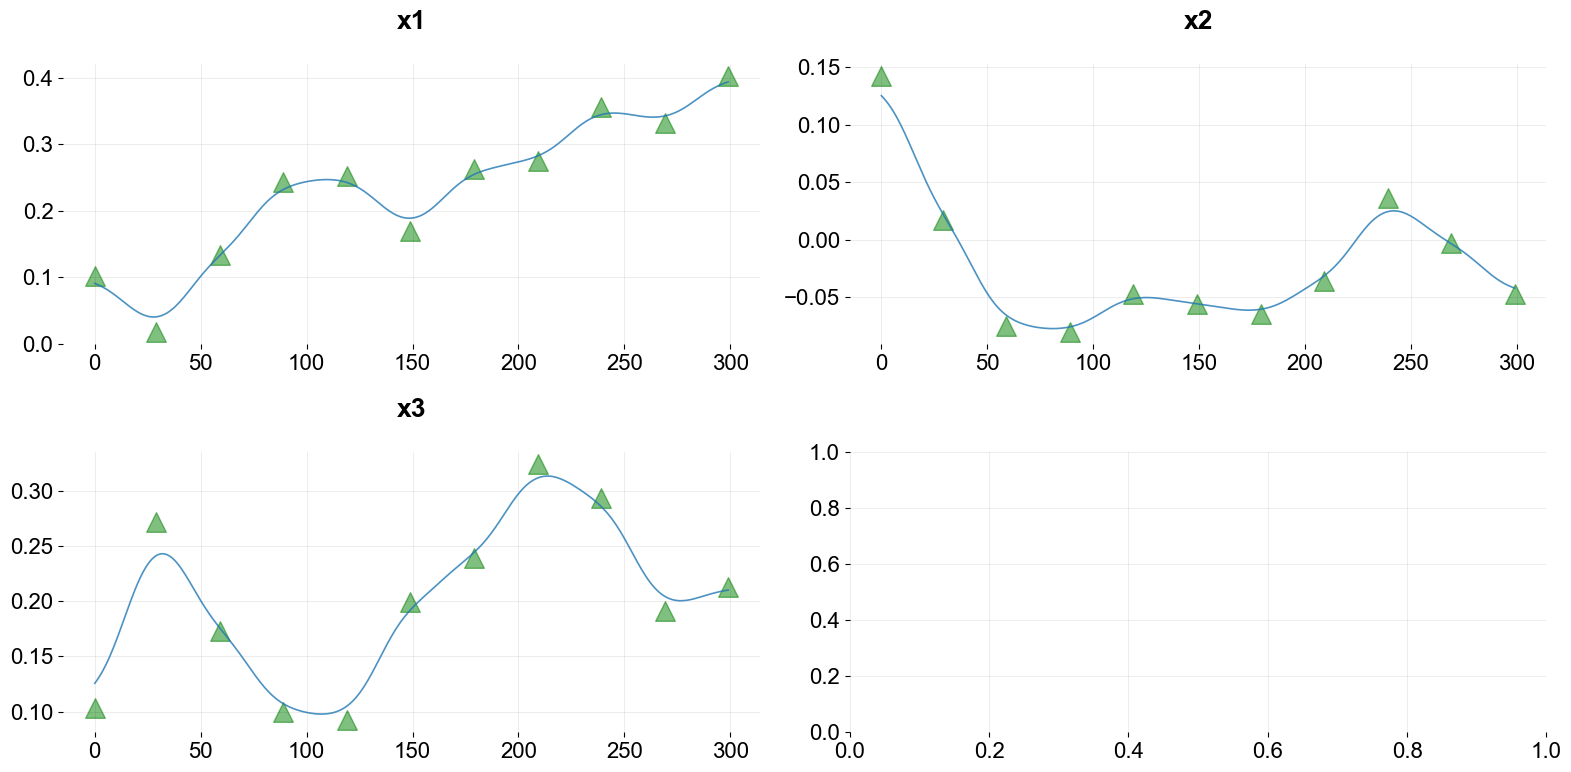

In [77]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [78]:
ktrx_pos = KTR(
    response_col='y',
    date_col='date',

    level_knot_scale=0.1,
    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[1.0] * len(regressor_col),
    regressor_knot_scale=[0.5] * len(regressor_col),
    # this is the only change fromp previous setting
    regressor_sign=['+'] * len(regressor_col),

    level_segments=10,
    regression_segments=10,
    
    regression_rho=0.05,
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,

    flat_multiplier=True,
)

INFO:root:Using 501 steps, 1000 samples, 0.2 learning rate and 100 particles for SVI.


In [79]:
ktrx_pos.fit(df=rw_data) 

INFO:root:Guessed max_plate_nesting = 1


Initial log joint probability = -1746.54
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -510.885     0.0488094       32.4314      0.2891      0.2891       23   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -508.614   0.000254171       33.3664      0.2697      0.8316       50   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -508.605   5.50184e-07       32.6815      0.3379           1       78   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70      -508.605   3.22758e-08       33.2243      0.1599      0.1599       94   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
step    0 loss = 2305.2, scale = 0.10699
step   50 loss = 441.04, scale = 0.28282
step  100 loss = 403.93, scale = 0.44586
step  150 loss

In [80]:
idx = 3

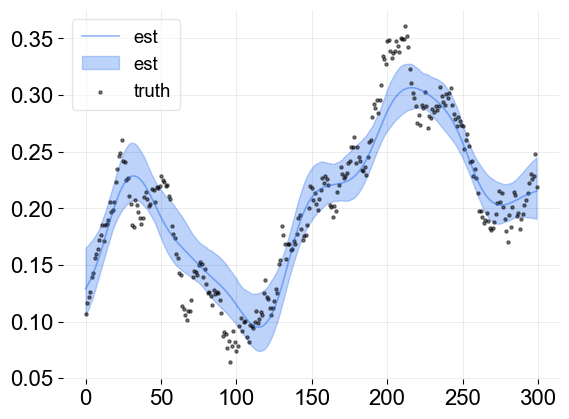

In [84]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True)

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', alpha=0.5, color=PredPal.PREDICTION_LINE.value)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est', 
                 alpha=0.3, color=PredPal.PREDICTION_LINE.value)
plt.scatter(x, rw_data['beta{}'.format(idx)], label='truth', s=5, alpha=0.5, color=PredPal.ACTUAL_OBS.value)
plt.legend();

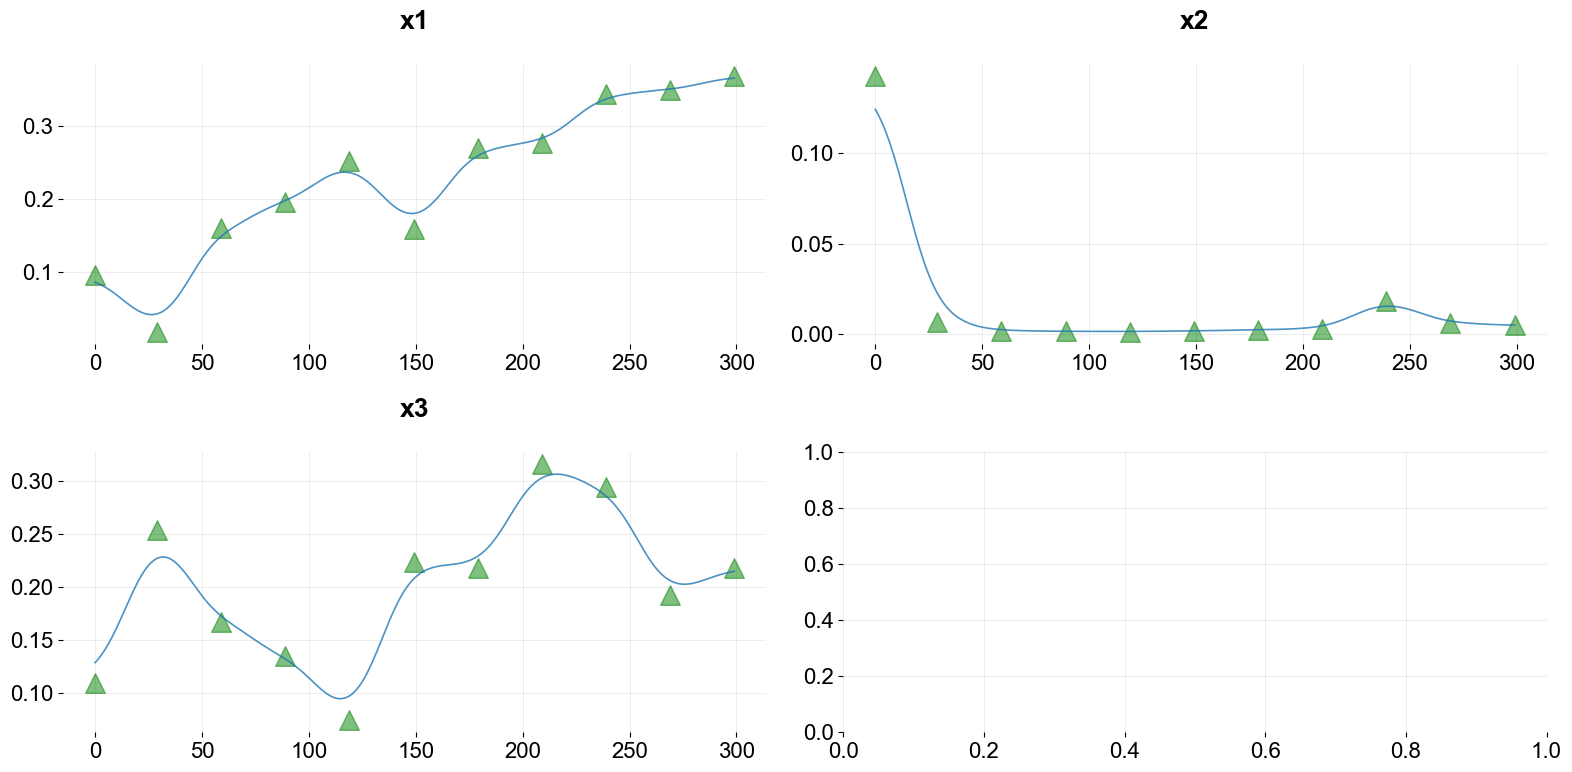

In [85]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))

# Sine - Cosine Coefficients Simulation Study

## Hierarchical structure with neutral sign assumption

Each coefficient follow Normal dist. with a latent mean which also follows a Normal dist.

In [87]:
p = 3
# define independent and response variables
regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]

In [86]:
%%time
ktrx_neutral = KTR(
    response_col='y',
    date_col='date',
    level_knot_scale=.1,

    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[10.0] * len(regressor_col),
    regressor_knot_scale=[2.0] * len(regressor_col),

    level_segments=10,
    regression_segments=10,
    
    regression_rho=0.05, 
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,
 
    flat_multiplier=True,
)

ktrx_neutral.fit(df=seas_data)                                  

INFO:root:Using 501 steps, 1000 samples, 0.2 learning rate and 100 particles for SVI.
INFO:root:Guessed max_plate_nesting = 1


Initial log joint probability = -3825.39
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -3515.31     0.0334474       33.1976           1           1       30   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      29      -3512.45     0.0327342       33.4794       0.001       0.001       81  LS failed, Hessian reset 
      39      -3511.95   9.99099e-05       33.5189    0.009193           1      100   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -3511.93   1.15041e-06       32.3198      0.3778     0.03778      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68      -3511.93   2.00515e-07       32.8999      0.1865           1      146   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
step    0 loss = 9428, sca

In [88]:
idx = 3

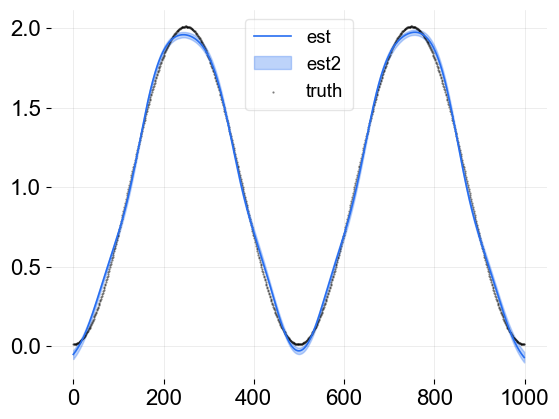

In [97]:
coef_mid, coef_lower, coef_upper  = ktrx_neutral.get_regression_coefs(include_ci=True)

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', color=PredPal.PREDICTION_LINE.value)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est2',
                 alpha=0.3, color=PredPal.PREDICTION_LINE.value)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=0.3, alpha=0.5,
            color = PredPal.ACTUAL_OBS.value)
plt.legend();

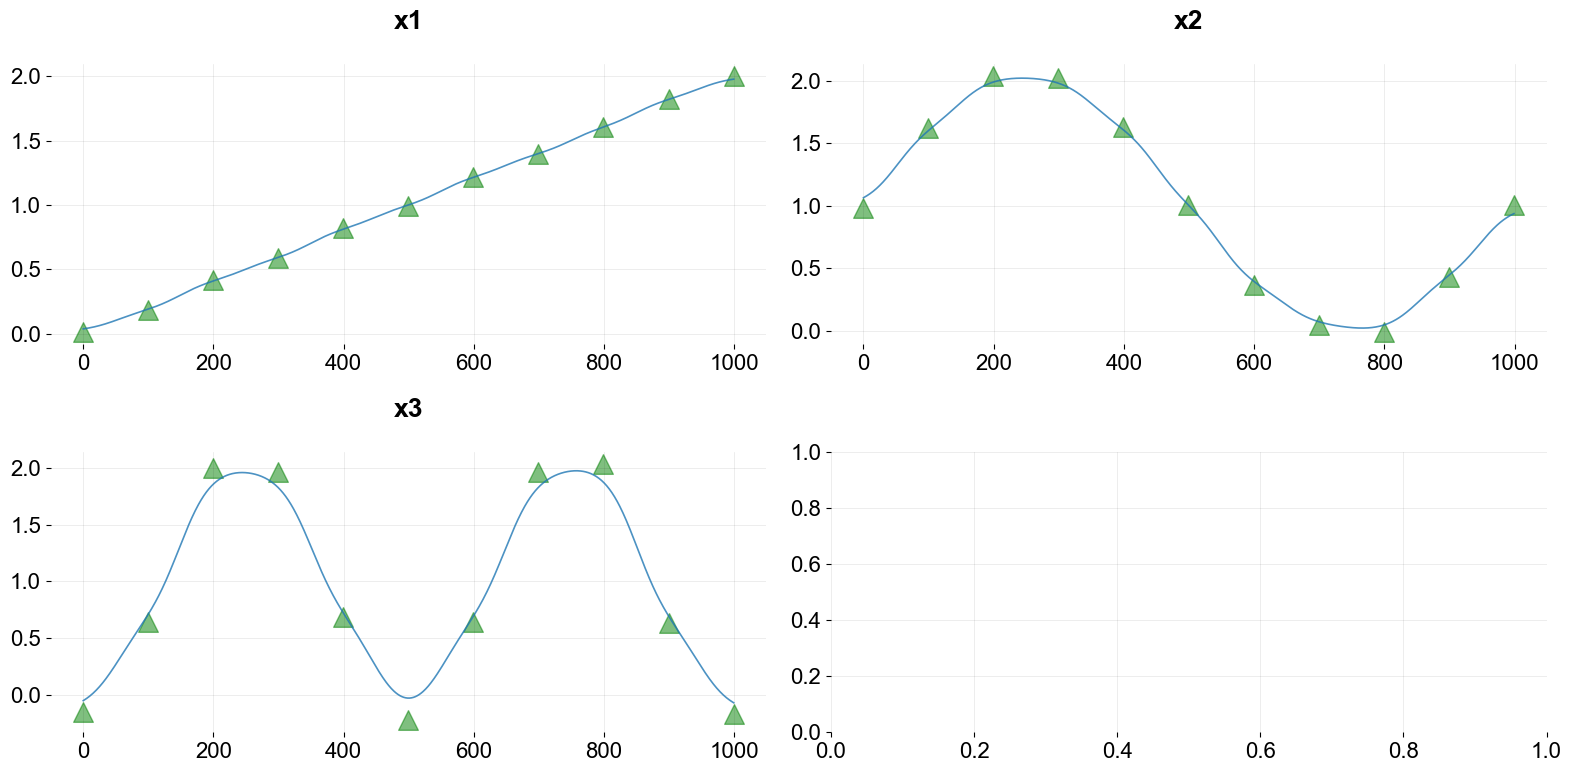

In [98]:
_ = ktrx_neutral.plot_regression_coefs(with_knot=True, figsize=(16, 8))

## Hierarchical structure with positive sign assumption

Most of setting are similar to previous setting.  However, this time we turn on sign as positive which implies all coefficient distribution are replaced by folded normal.

In [100]:
%%time
ktrx_pos = KTR(
    response_col='y',
    date_col='date',
    level_knot_scale=.1,

    regressor_col=regressor_col,
    regressor_init_knot_loc=[0] * len(regressor_col),
    regressor_init_knot_scale=[10.0] * len(regressor_col),
    regressor_knot_scale=[2.0] * len(regressor_col),
    # this is the only change fromp previous setting
    regressor_sign=['+'] * len(regressor_col),

    level_segments=10,
    regression_segments=10,
    
    regression_rho=0.05, 
    prediction_percentiles=[2.5, 97.5],
    seed=2020,
    num_steps=501,
    num_sample=1000,
    learning_rate=0.2,
    learning_rate_total_decay=0.05,
    verbose=True,
    message=50,
 
    flat_multiplier=True,
)

ktrx_pos.fit(df=seas_data)                                  

INFO:root:Using 501 steps, 1000 samples, 0.2 learning rate and 100 particles for SVI.
INFO:root:Guessed max_plate_nesting = 1


Initial log joint probability = -3825.39
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -3515.31     0.0334474       33.1976           1           1       30   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      29      -3512.45     0.0327342       33.4794       0.001       0.001       81  LS failed, Hessian reset 
      39      -3511.95   9.99099e-05       33.5189    0.009193           1      100   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -3511.93   1.15041e-06       32.3198      0.3778     0.03778      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68      -3511.93   2.00515e-07       32.8999      0.1865           1      146   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
step    0 loss = 14607, sc

In [101]:
idx = 3

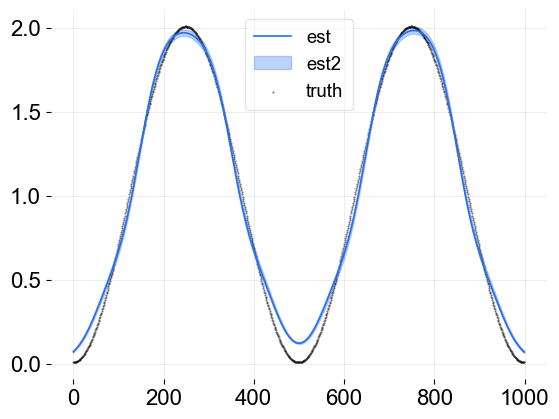

In [102]:
coef_mid, coef_lower, coef_upper  = ktrx_pos.get_regression_coefs(include_ci=True)

x = np.arange(coef_mid.shape[0])

plt.plot(x, coef_mid['x{}'.format(idx)], label='est', color=PredPal.PREDICTION_LINE.value)
plt.fill_between(x, coef_lower['x{}'.format(idx)], coef_upper['x{}'.format(idx)], label='est2',
                 alpha=0.3, color=PredPal.PREDICTION_LINE.value)
plt.scatter(x, seas_data['beta{}'.format(idx)], label='truth', s=0.3, alpha=0.5,
            color = PredPal.ACTUAL_OBS.value)
plt.legend();

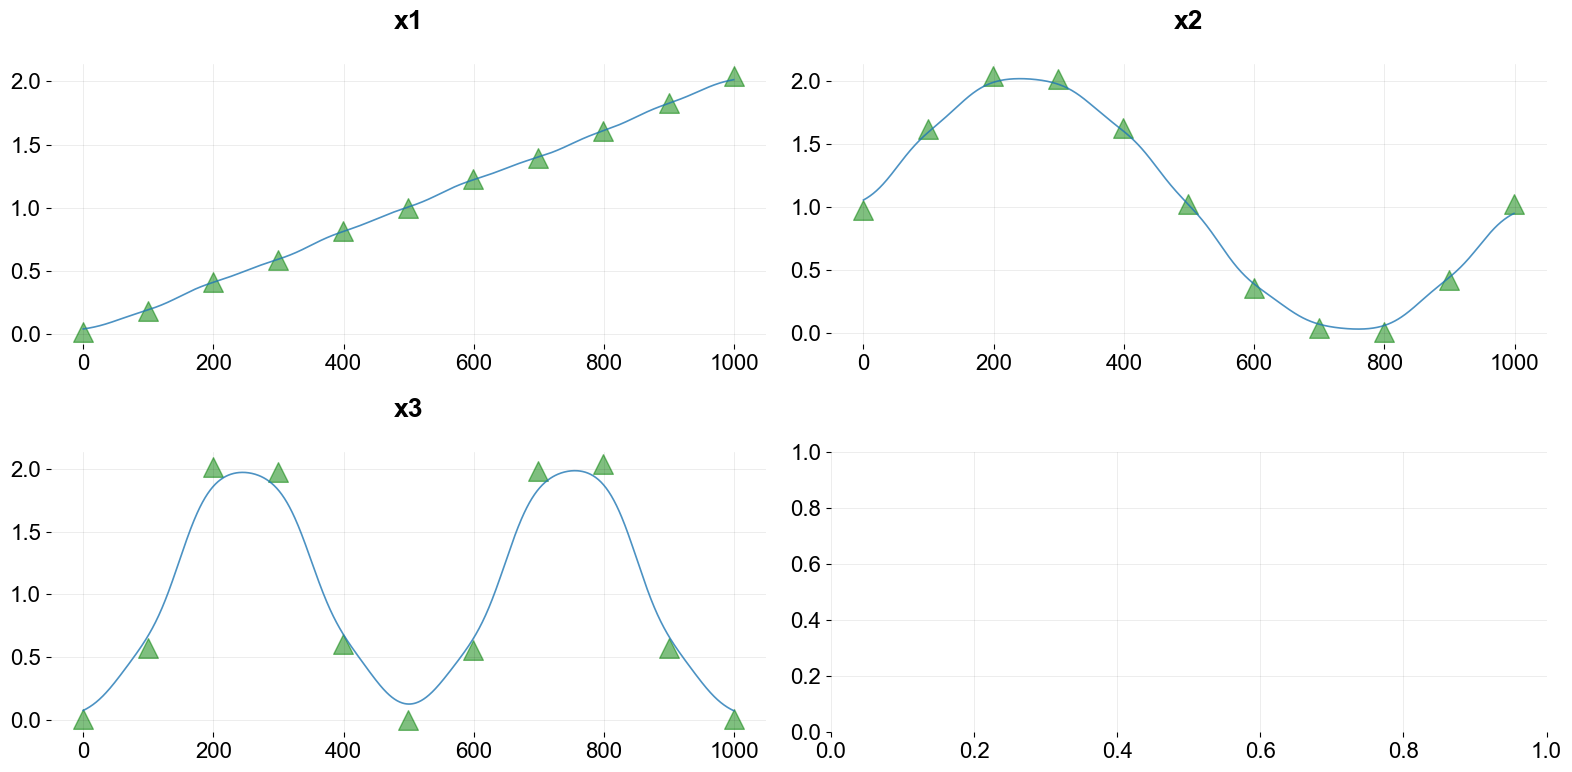

In [103]:
_ = ktrx_pos.plot_regression_coefs(with_knot=True, figsize=(16, 8))